In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

In [101]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)


CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [102]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
#data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=pd.concat([data_water, data_ice, data_mixed])
#data_all=pd.concat([data_ice])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df_truth=data_all.copy()

data_all=data_all[data_all['COT']<3.6]

#data_all=hf.add_MSI_noise(data_all,channel_labels)

In [103]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B12']

X_truth=df_truth[X_labels]

df=data_all.copy()
#df=hf.normalise_input_df(data_all,X_labels)
#df=hf.add_noise(df,X_labels,sigma=0.001)

##Split data##
X=df[X_labels]
y=df[y_labels]

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.05)

X_test_truth=X_truth.iloc[X_test.index] #Save truth values without normalisation

In [122]:
import random

val_size=0.05
validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(X_train['Cloud_B02'])*val_size)))
train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]

quantiles=np.array([0.1,0.5,0.9])
batch_size=500

KeyboardInterrupt: 

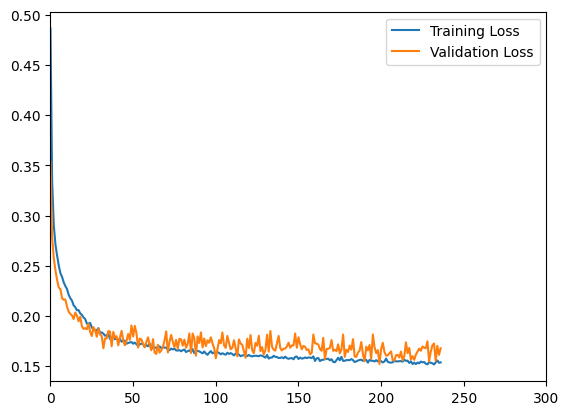

In [123]:
nepochs=300

model=QuantileNetwork(quantiles=quantiles)

# Add everything but the output layer
n_nodes=64
sequence=nn.Sequential(
    nn.Linear(len(X_labels),n_nodes),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(n_nodes,n_nodes),
    nn.ReLU(),
    nn.Linear(n_nodes, len(quantiles)*len(y_labels)) #Output dimesion is number of quantiles times number of target variables
)
model.fit(X_train.to_numpy(),y_train.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence,
          lr=0.003,
          data_norm=True,
          verbose=False,
          plot_training=True)

In [115]:
preds = model.predict(X_test.to_numpy())
mse=mean_squared_error(y_test.to_numpy(),preds[:,:,1])
psnr=QuantileNetwork.PSNR(y_test,preds[:,:,1])
quant_rate=QuantileNetwork.quant_rate(y_test.to_numpy(),preds)
r2=r2_score(y_test.to_numpy(),preds[:,:,1])

In [116]:
print("MSE: "+str(mse))
print("PSNR: "+str(psnr))
print("Quant_rate: "+str(quant_rate))
print("R2 score: "+str(r2))

MSE: 0.0029164596091402887
PSNR: 25.229353861740485
Quant_rate: [0.08348624 0.51559633 0.9293578 ]
R2 score: 0.9208696017108113


## Visualise

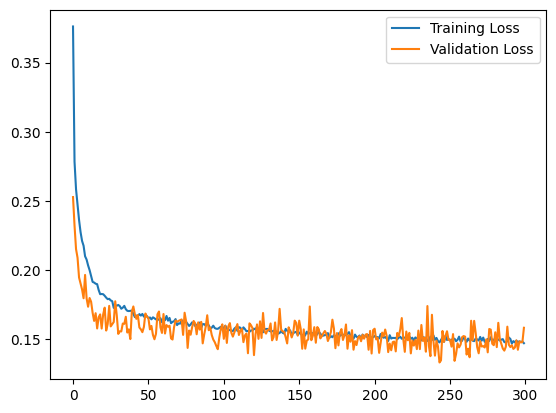

In [117]:
plt.plot(model.train_loss.data.cpu().numpy())
plt.plot(model.val_loss.data.cpu().numpy())
plt.legend(['Training Loss','Validation Loss'])

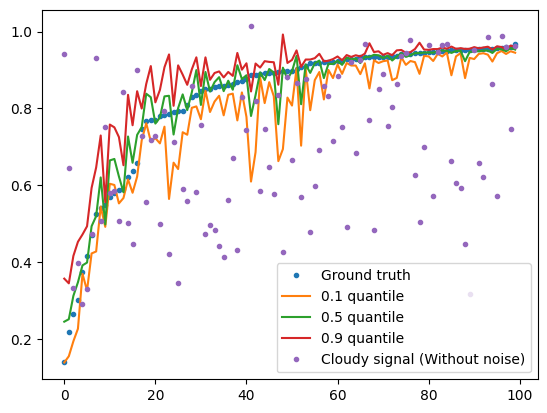

In [118]:
samples=100
channel=10
#Get ground truth y
y_plot=y_test.to_numpy()[:,0]
y_plot=y_plot[0:samples]
sort_ind=np.argsort(y_plot)
y_plot_sort=y_plot[sort_ind]

#Get y predictions
y_pred=preds.copy()[:,0]
y_pred=y_pred[0:samples,:]
y_pred_sort=y_pred[sort_ind,:]

# Get cloudy signal
cloudy=X_test_truth.to_numpy()[:,channel]
cloudy=cloudy[0:samples]
cloudy_sort=cloudy[sort_ind]

plt.plot(y_plot_sort,'.')
plt.plot(y_pred_sort)
plt.plot(cloudy_sort,'.')
plt.legend(['Ground truth','0.1 quantile', '0.5 quantile','0.9 quantile','Cloudy signal (Without noise)'])
plt.show()


/tmp/ipykernel_158792/936637859.py:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(x=np.linspace(0,samples,samples)


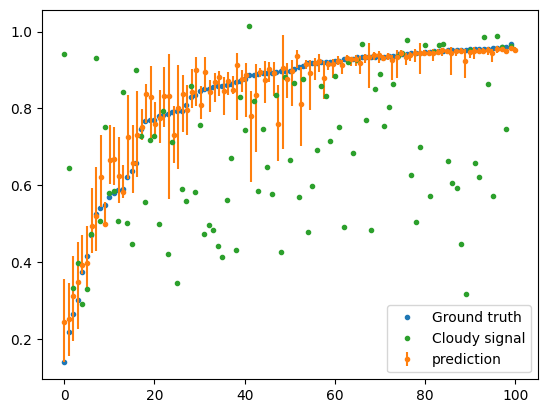

In [119]:
samples=100
channel=10
#Get ground truth y
y_plot=y_test.to_numpy()[:,0]
y_plot=y_plot[0:samples]
sort_ind=np.argsort(y_plot)
y_plot_sort=y_plot[sort_ind]

#Get y predictions
y_pred=preds.copy()
y_pred=y_pred[0:samples,:]
y_pred_sort=y_pred[sort_ind,:]
y_pred_sort=y_pred_sort[:,0]

# Get cloudy signal
cloudy=X_test_truth.to_numpy()[:,channel]
cloudy=cloudy[0:samples]
cloudy_sort=cloudy[sort_ind]


plt.plot(y_plot_sort,'.')
plt.errorbar(x=np.linspace(0,samples,samples)
             ,y=y_pred_sort[:,1],
             yerr=[np.abs(y_pred_sort[:,1]-y_pred_sort[:,0]),np.abs(y_pred_sort[:,1]-y_pred_sort[:,2])],
             marker='.',fmt='.')
plt.plot(cloudy_sort,'.')
plt.legend(['Ground truth','Cloudy signal','prediction'])
plt.show()

(-0.15153, 1.17228)

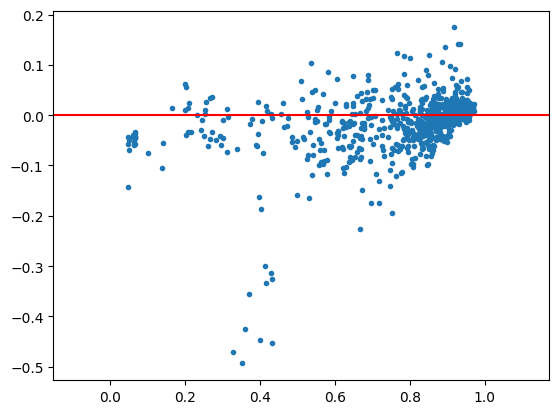

In [120]:
## Residual graph for channel 11

y_11=y_test.to_numpy()[:,0]
y_pred=preds[:,0,:]

res=y_11-y_pred[:,1]

plt.plot(y_11,res,'.')
plt.hlines(0,xmin=-1,xmax=10,colors='r')
plt.xlim((np.min(y_11)-0.2,np.max(y_11)+0.2))


In [121]:
#hf.save_model_and_test_data(filepath='pytorch_models/'+str(nepochs)+'epochs',model=model,X_test=X_test,y_test=y_test)